# Introduction

In today's increasingly connected world, security has never been more crucial. As attackers continue to evolve and become more sophisticated in their methods, it's essential for users to be equipped with effective tools to identify malicious URLs. This report focuses on helping everyday users with a simple yet powerful technique using TF-IDF (Term Frequency-Inverse Document Frequency) to detect potentially harmful URLs.

# Method Overview
Since URL is just simple document, a combination of Bags of Word and TF-IDF can be used to extract features used to determine wether an URL is legit.

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from io import StringIO

# Data Exploration

This report will utilize a dataset from Kaggle that includes over 600,000 URLs classified into four categories: benign, defacement, phishing, and malware. This dataset will serve as the input for the learning model.

####Preprocessing
While making sense of our data, we decided to remove any null rows from the dataset in Line 8.

In [3]:
df = pd.read_csv('malicious_phish.csv')
df = pd.DataFrame(df)
df = df.sample(n=20000)
col = ['url','type']
df = df[col]

#Deleting nulls
df = df[pd.notnull(df['url'])]

df['category_id'] = df['type'].factorize()[0]
category_id_df = df[['type', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'type']].values)

In [4]:
df.head()

,url,type,category_id
12837,manta.com/c/mmfgmr3/robert-l-besanceney,benign,0
220539,http://www.alexanderstiftung.de/index.php?view...,defacement,1
238915,lovemakers.webstarts.com/splash_page_v2.html,benign,0
445877,myspace.com/jrb4053,benign,0
626214,www.kuro5hin.org/?op=displaystory;sid=2002/4/6...,phishing,2


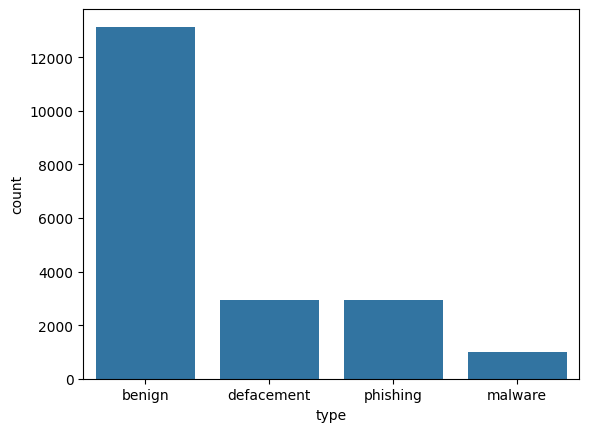

In [8]:
# prompt: visualize df

import matplotlib.pyplot as plt
sns.countplot(x='type', data=df)
plt.show()

The following code represent for each different length the number of URLs.

Text(0.5, 0, 'URL Length')

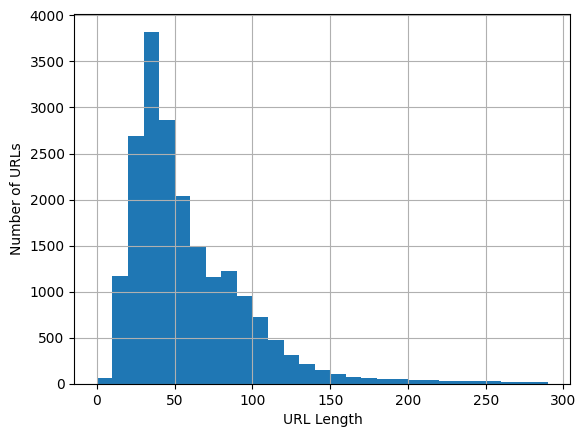

In [9]:
%matplotlib inline
lens = df.url.str.len()
lens.hist(bins = np.arange(0,300,10))
plt.ylabel("Number of URLs")  # y-axis label
plt.xlabel("URL Length")      # x-axis label

# Method - Logistic Regression


For our tokenization function, we first split the text by the slash delimiter and then apply TF-IDF to create our Bag of Words. We also ignore all the top-level domains.

In [ ]:
def getTokens(input):
    tokensBySlash = str(input.encode('utf-8')).split('/')
    allTokens=[]
    for i in tokensBySlash:
        tokens = str(i).split('-')
        tokensByDot = []
        for j in range(0,len(tokens)):
            tempTokens = str(tokens[j]).split('.')
            tokentsByDot = tokensByDot + tempTokens
        allTokens = allTokens + tokens + tokensByDot
    allTokens = list(set(allTokens))
    allTokens = allTokens = [token for token in allTokens if token not in ['com', 'org', 'net', 'gov']]
    return allTokens

In [ ]:
y = [d[1]for d in df] #labels
myUrls = [d[0]for d in df] #urls
vectorizer = TfidfVectorizer(tokenizer=getTokens, use_idf=True, smooth_idf=True, sublinear_tf=False)
features = vectorizer.fit_transform(df.url).toarray()
labels = df.type
features.shape

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(20000, 45699)

# Training

In [ ]:
model = LogisticRegression(random_state=0)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.20, random_state=0)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)
clf = LogisticRegression(random_state=0)
clf.fit(X_train,y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print ('train accuracy =', train_score)
print ('test accuracy =', test_score)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

train accuracy = 0.8930625
test accuracy = 0.86575


# Result

Text(0.5, 23.52222222222222, 'Predicted')

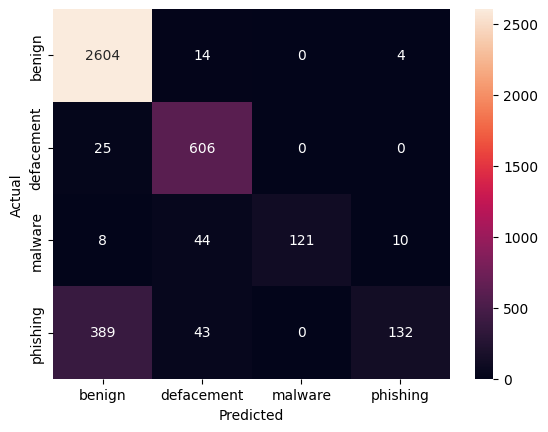

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat,
            annot=True,
            fmt='d',
            xticklabels = category_id_df.type.values,
            yticklabels = category_id_df.type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

      benign       0.86      0.99      0.92      2622
  defacement       0.86      0.96      0.91       631
     malware       1.00      0.66      0.80       183
    phishing       0.90      0.23      0.37       564

    accuracy                           0.87      4000
   macro avg       0.91      0.71      0.75      4000
weighted avg       0.87      0.87      0.84      4000



#Result and Future Work

Based on our Confusion Matrix, we can see that there is a challenge in classifying benign versus phishing URLs. However, the model did a very good job in identifying legitimate URLs. For future work, we need to delve into the context or attributes of the URLs to determine if they are phishing or not.